## DataSet History:
#### The data scientists at BigMart have collected sales data for 1559 products across 10 stores in different cities for the year 2013. Now each product has certain attributes that sets it apart from other products. Same is the case with each store.
#### The aim is to build a predictive model to find out the sales of each product at a particular store so that it would help the decision makers at BigMart to find out the properties of any product or store, which play a key role in increasing the overall sales.

In [109]:
# import dependencies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
sns.set_theme(style="darkgrid")
%matplotlib inline


In [110]:
# load data to a pandas dataframe
# df = pd.read_csv("/kaggle/input/bigmart-sales-data/Train.csv")
df = pd.read_csv("Train.csv")

df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


# EDA:

In [111]:
def data_analysis(data):
    
    # The shape of the data
    print("The shape of the data set:")
    print(f"The data set consists of {data.shape[0]} rows and {data.shape[1]} columns.")
    
    print('\n***********************************************')
    # Missing Values Check
    print("The existence of missing values in each column:")
    print(data.isnull().any())
    
    print('\n***********************************************')
    # Info of the data
    print("General information about the data:")
    print(data.info())
    
    print('\n***********************************************')
    # Number of unique values in each column
    print("The number of unique values in each column:")
    print(data.nunique())

In [112]:
data_analysis(df)

The shape of the data set:
The data set consists of 8523 rows and 12 columns.

***********************************************
The existence of missing values in each column:
Item_Identifier              False
Item_Weight                   True
Item_Fat_Content             False
Item_Visibility              False
Item_Type                    False
Item_MRP                     False
Outlet_Identifier            False
Outlet_Establishment_Year    False
Outlet_Size                   True
Outlet_Location_Type         False
Outlet_Type                  False
Item_Outlet_Sales            False
dtype: bool

***********************************************
General information about the data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7

In [113]:
# view the statistics of data
df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [114]:
# check for missing values
df.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [115]:
# check for duplicated values
sum(df.duplicated())

0

### Observation:

* Missing values for Item_Weight & Outlet_Size
* Correct the values for Item_Fat_Content
* Label Encoding needs to be done for Categorical Items:
    - Item_Fat_Content
    - Item_Type
    - Outlet_Size
    - Outlet_Location_Type
    - Outlet_Type

# Data Preprocessing:

## 1. Handling The missing values

In [116]:
missing_data = ['Item_Weight', 'Outlet_Size']
for i in missing_data:
    fill_list = df[i].dropna().tolist()
    df[i] = df[i].fillna(pd.Series(np.random.choice(fill_list , size = len(df.index))))

In [117]:
df.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

## 2. Handling The uncorrect values

In [118]:
df.Item_Fat_Content.value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

It is clear that the types of Fats are Low fat and regular but it is duplicated in the data with different names

In [119]:
df.replace({'Item_Fat_Content':{'LF':'Low Fat', 'low fat':'Low Fat', 'reg':'Regular'}}, inplace=True)

In [120]:
df.Item_Fat_Content.value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

# Data Visualization:

## Univariate Analysis:

In [121]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                8523 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                8523 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


### 1. Item_Identifier:            

In [122]:
df.Item_Identifier.value_counts()

FDW13    10
FDG33    10
NCY18     9
FDD38     9
DRE49     9
         ..
FDY43     1
FDQ60     1
FDO33     1
DRF48     1
FDC23     1
Name: Item_Identifier, Length: 1559, dtype: int64

### 2. Item_Weight

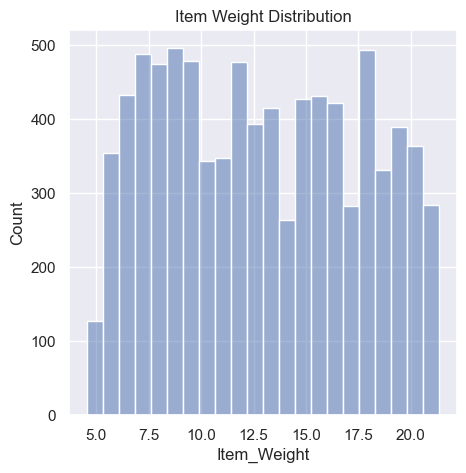

In [123]:
plt.figure(figsize=(5,5))
plt.title("Item Weight Distribution")
sns.histplot(data=df, x='Item_Weight', alpha=0.5)
plt.show()

It is clear that the max Item_weight ranges between (6,10) and at 17.5

### 3. Item_Fat_Content

In [124]:
df.Item_Fat_Content.value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

<AxesSubplot:xlabel='Item_Fat_Content', ylabel='count'>

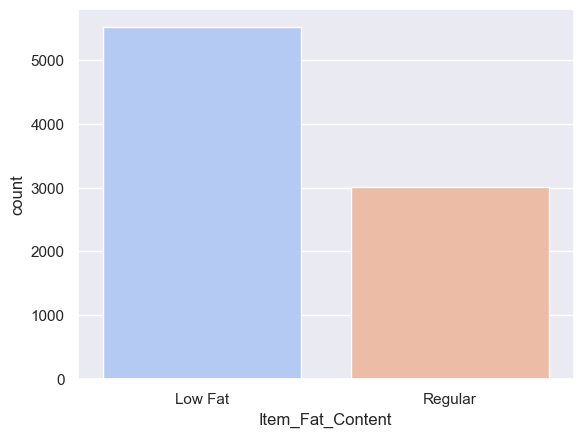

In [125]:
sns.countplot(data=df, x= "Item_Fat_Content", palette="coolwarm")

### 4. Item_Visibility            

In [126]:
df.Item_Visibility.value_counts()

0.000000    526
0.076975      3
0.162462      2
0.076841      2
0.073562      2
           ... 
0.013957      1
0.110460      1
0.124646      1
0.054142      1
0.044878      1
Name: Item_Visibility, Length: 7880, dtype: int64

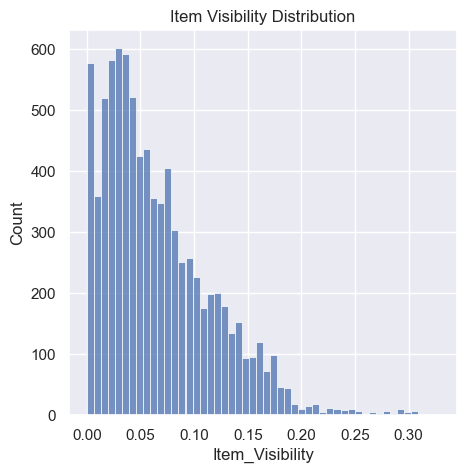

In [127]:
plt.figure(figsize=(5,5))
plt.title("Item Visibility Distribution")
sns.histplot(data=df, x='Item_Visibility', palette='husl')
plt.show()

it is clear that the item visibility ranges from 0 to less than 0.2

### 5. Item_Type

In [128]:
df.Item_Type.value_counts()

Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64

<AxesSubplot:title={'center':' The Item Types'}, xlabel='count', ylabel='Item_Type'>

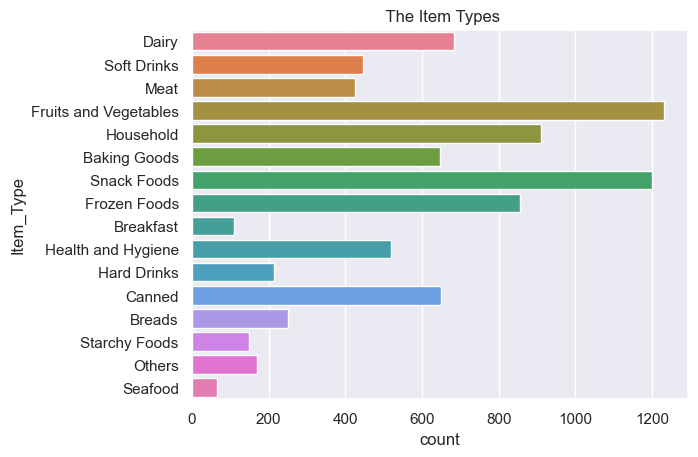

In [129]:
plt.title(" The Item Types")
sns.countplot(data=df, y='Item_Type', palette='husl')

The Store sells:
- Alot of Fruits and Veges, Snack Foods products
- Diary, Household, Frozen food product in normal ranges
- Less Seafood and breakfast products

### 6.Item_MRP 

In [130]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                8523 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                8523 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [131]:
df.Item_MRP.max()

266.8884

<AxesSubplot:title={'center':'The Item MRP Distribution'}>

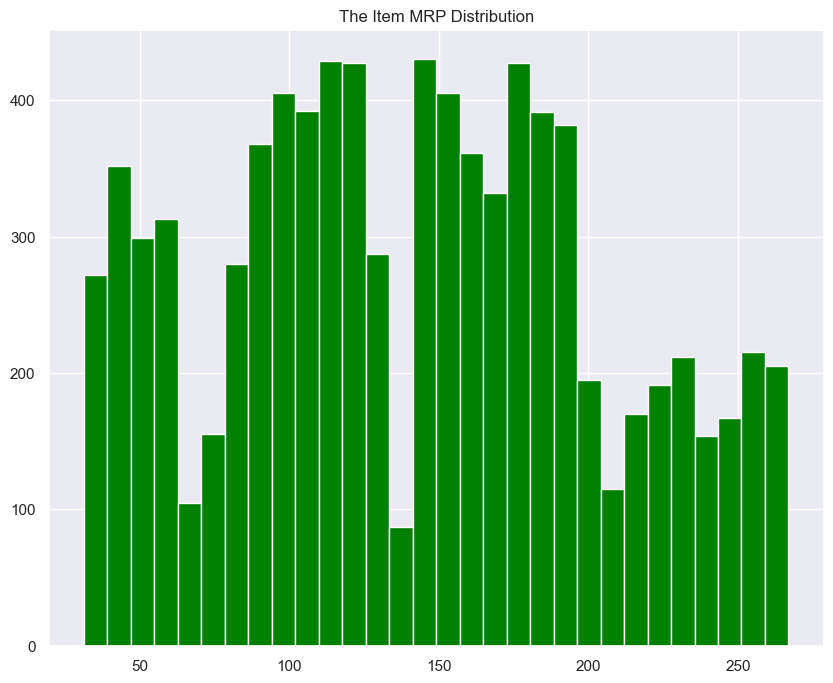

In [132]:
plt.title('The Item MRP Distribution')
df['Item_MRP'].hist(figsize=(10,8), bins =30, color = 'green')

The max values of item MRP are between (100, 200)

### 7. Outlet_Establishment_Year

<AxesSubplot:title={'center':'Outlet Establishment Year Distribution'}, xlabel='Outlet_Establishment_Year', ylabel='count'>

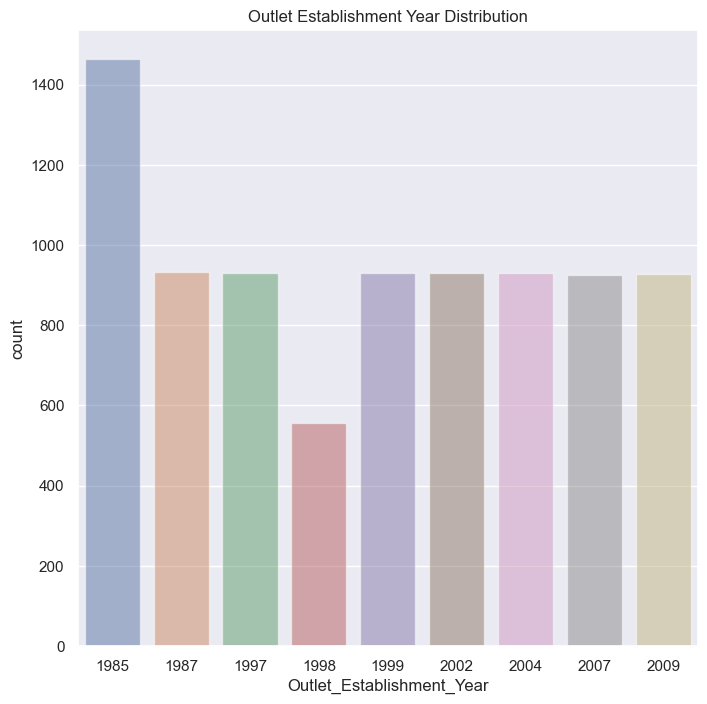

In [133]:
plt.figure(figsize=(8,8))
plt.title("Outlet Establishment Year Distribution")
sns.countplot(data=df, x='Outlet_Establishment_Year', alpha=0.5)

In [134]:
df.Outlet_Size .value_counts()

Medium    3861
Small     3355
High      1307
Name: Outlet_Size, dtype: int64

### 8. Outlet_Size 

In [135]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                8523 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                8523 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


<AxesSubplot:title={'center':' The Outlet Size '}, xlabel='Outlet_Size', ylabel='count'>

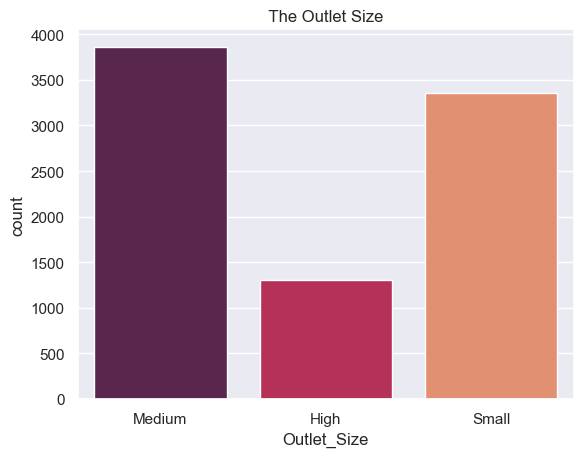

In [136]:
plt.title(" The Outlet Size ")
sns.countplot(data=df, x='Outlet_Size', palette='rocket')

The max outlet size is medium

### 9. Outlet_Location_Type

In [137]:
df.Outlet_Location_Type.value_counts()

Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: Outlet_Location_Type, dtype: int64

<AxesSubplot:title={'center':' The Outlet Location Type'}, xlabel='Outlet_Location_Type', ylabel='count'>

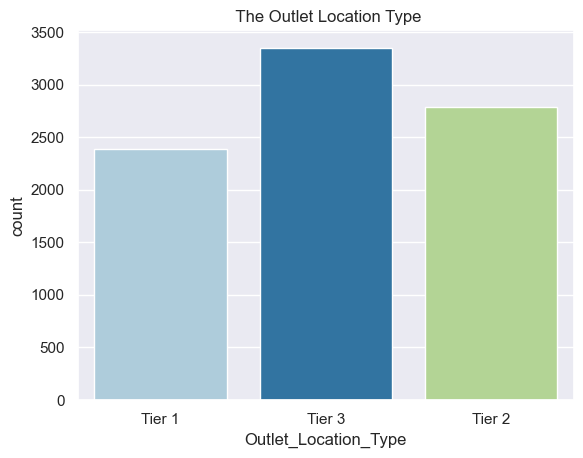

In [138]:
plt.title(" The Outlet Location Type")
sns.countplot(data=df, x='Outlet_Location_Type', palette='Paired')

The max Outlet Location type is Tier 3

### 10. Outlet_Type

In [139]:
df.Outlet_Type.value_counts()

Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     935
Supermarket Type2     928
Name: Outlet_Type, dtype: int64

<AxesSubplot:title={'center':' The Outlet Type'}, xlabel='count', ylabel='Outlet_Type'>

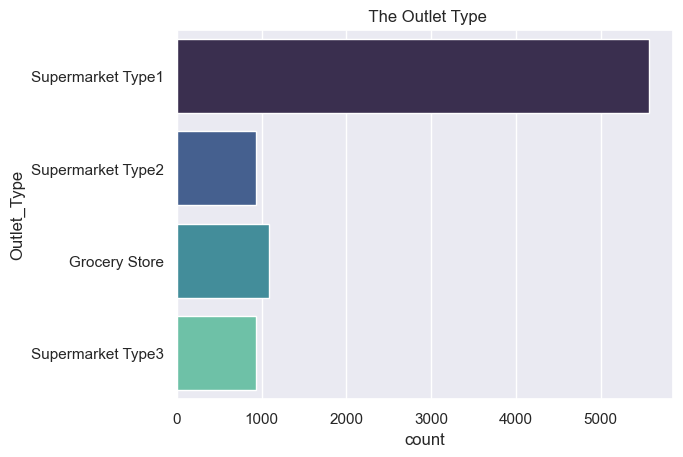

In [140]:
plt.title(" The Outlet Type")
sns.countplot(data=df, y='Outlet_Type', palette='mako')

The max Outlet Type is Supermarket Type1

### 11. Item_Outlet_Sales 

In [141]:
df.Item_Outlet_Sales.value_counts()

958.7520     17
1342.2528    16
703.0848     15
1845.5976    15
1278.3360    14
             ..
4124.6310     1
6622.7126     1
1614.5650     1
5602.7070     1
2778.3834     1
Name: Item_Outlet_Sales, Length: 3493, dtype: int64

<AxesSubplot:title={'center':'SalesItem MRP Distribution'}, xlabel='Item_Outlet_Sales', ylabel='Count'>

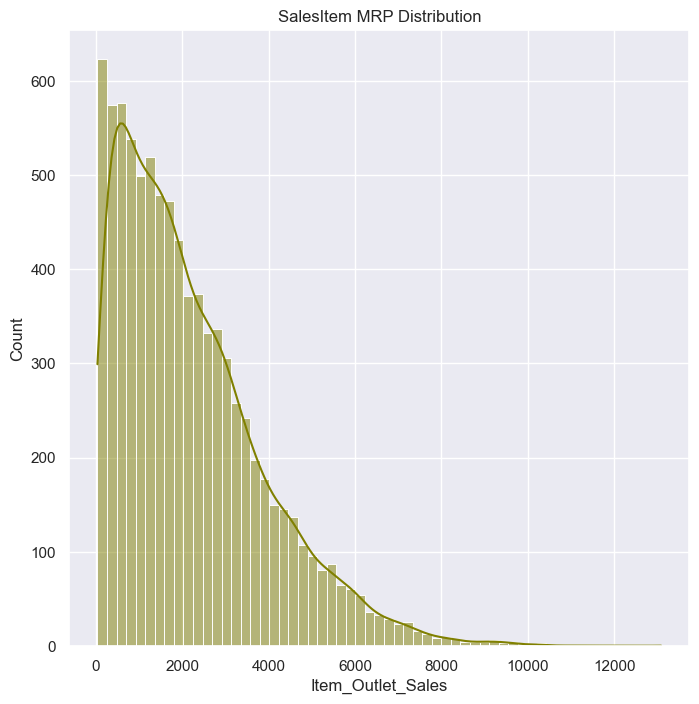

In [142]:
plt.figure(figsize=(8,8))
plt.title("SalesItem MRP Distribution")
sns.histplot(data=df, x='Item_Outlet_Sales', kde=True, alpha=0.5, color = 'olive')

## Bivariate Analysis

## 1. Item_Outlet_Sales with Item_Fat_Content

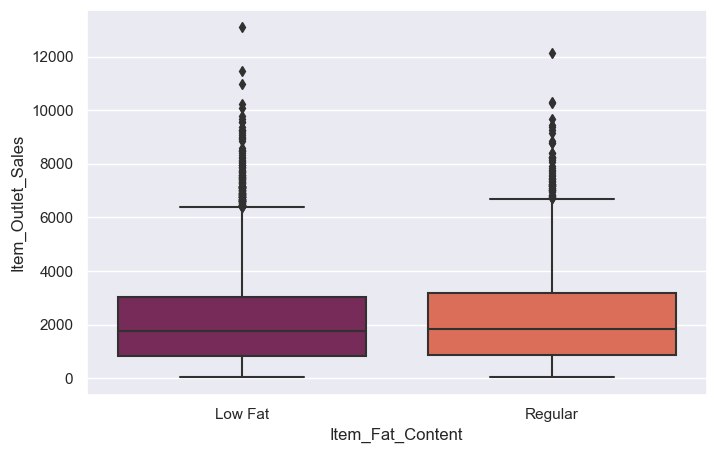

In [143]:
plt.figure(figsize = (8,5))
sns.boxplot(x='Item_Fat_Content', y='Item_Outlet_Sales', data=df, palette="rocket")
plt.show()

## 2. Item_Outlet_Sales & Outlet_Location_Type

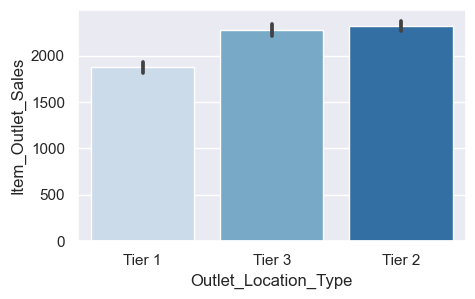

In [144]:
plt.figure(figsize=(5,3))
sns.barplot(data=df, x = 'Outlet_Location_Type', y='Item_Outlet_Sales',palette='Blues')
plt.show()

## 3. Item_Fat_Content & Item_Weight

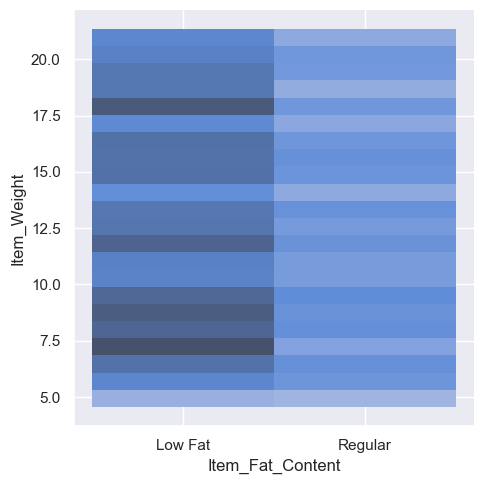

In [145]:
sns.displot(data=df, y='Item_Weight', x='Item_Fat_Content', palette='coolwarm')

## 4. Item_Outlet_Sales & Outlet_Type


<AxesSubplot:xlabel='Outlet_Type', ylabel='Item_Outlet_Sales'>

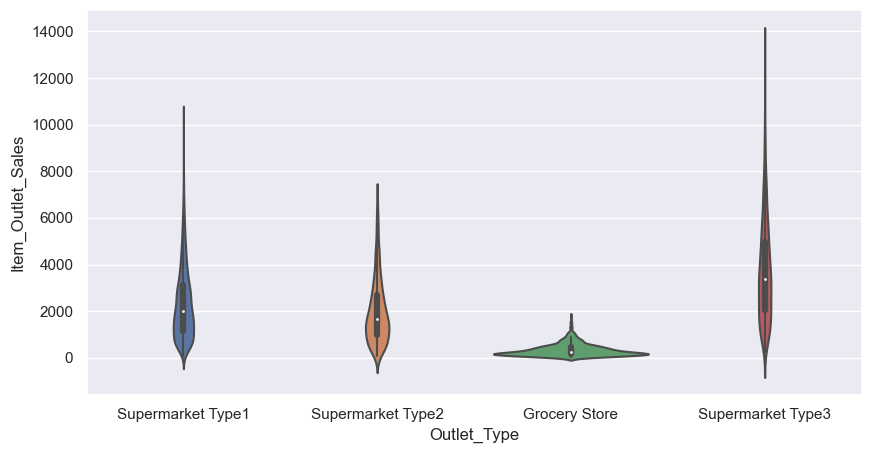

In [146]:
plt.figure(figsize=(10,5))
sns.violinplot(data=df, x='Outlet_Type', y='Item_Outlet_Sales')

## Feature Engineering:

In [147]:
#Get the first two characters of ID:
df['Item_Type_Combined'] = df['Item_Identifier'].apply(lambda x: x[0:2])
#Rename them to more intuitive categories:
df['Item_Type_Combined'] = df['Item_Type_Combined'].map({'FD':'Food',
                                                             'NC':'Non-Consumable',
                                                             'DR':'Drinks'})
df['Item_Type_Combined'].value_counts()

Food              6125
Non-Consumable    1599
Drinks             799
Name: Item_Type_Combined, dtype: int64

## 5. Outlet_Type & Item_Identifier

<AxesSubplot:xlabel='Outlet_Type', ylabel='Item_Outlet_Sales'>

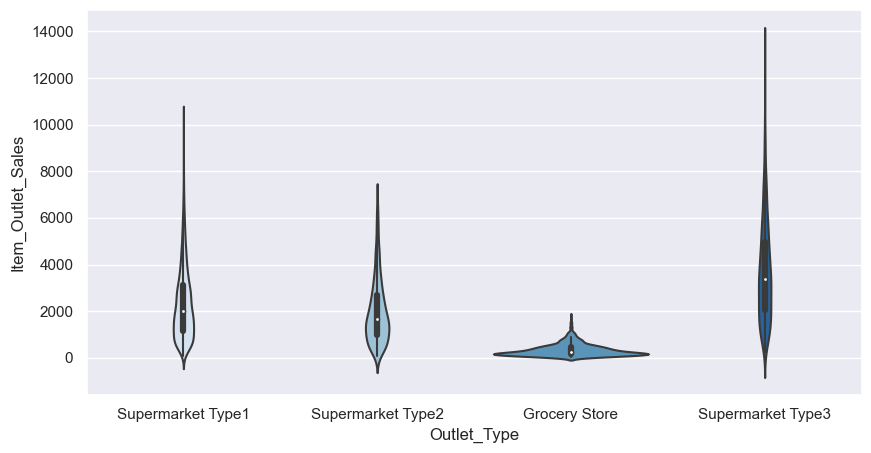

In [148]:
plt.figure(figsize=(10,5))
sns.violinplot(data=df, x='Outlet_Type', y='Item_Outlet_Sales', palette='Blues')

## Correlation

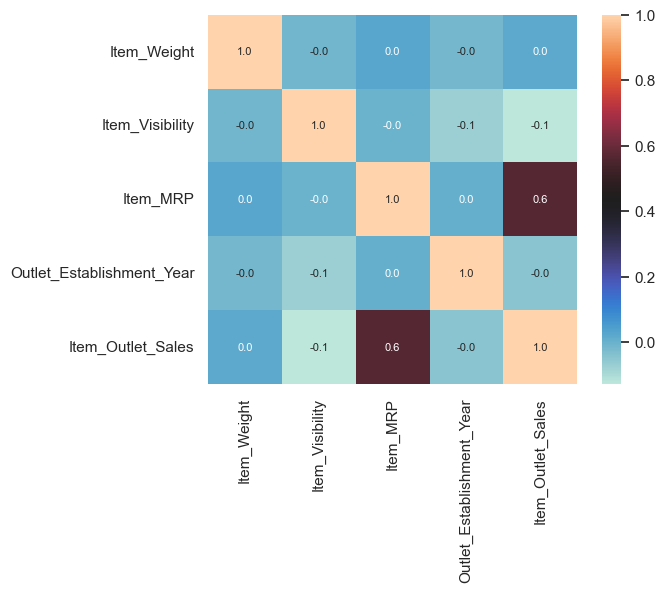

In [149]:
correlation = df.corr()
sns.heatmap(correlation, cbar=True, square=True, fmt='.1f', annot=True, annot_kws={'size':8}, cmap='icefire')
plt.show()

## Encoding:

The Categorical data are Item_Identifier, Item_Fat_Content, Item_Type, Outlet_Identifier,
Outlet_Size, Outlet_Location_Type, Outlet_Type

In [150]:
# Create the encoder variable
encoder = LabelEncoder()

cat_df = df.select_dtypes(include=['object'])

for i in cat_df:
    # fit the categoral feature to the encoding method
    df[i] = encoder.fit_transform(df[i])
    

In [151]:
cat_df.columns

Index(['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type',
       'Item_Type_Combined'],
      dtype='object')

## Outliers Handling:

Item_Identifier                  AxesSubplot(0.125,0.77;0.168478x0.11)
Item_Weight                   AxesSubplot(0.327174,0.77;0.168478x0.11)
Item_Fat_Content              AxesSubplot(0.529348,0.77;0.168478x0.11)
Item_Visibility               AxesSubplot(0.731522,0.77;0.168478x0.11)
Item_Type                       AxesSubplot(0.125,0.638;0.168478x0.11)
Item_MRP                     AxesSubplot(0.327174,0.638;0.168478x0.11)
Outlet_Identifier            AxesSubplot(0.529348,0.638;0.168478x0.11)
Outlet_Establishment_Year    AxesSubplot(0.731522,0.638;0.168478x0.11)
Outlet_Size                     AxesSubplot(0.125,0.506;0.168478x0.11)
Outlet_Location_Type         AxesSubplot(0.327174,0.506;0.168478x0.11)
Outlet_Type                  AxesSubplot(0.529348,0.506;0.168478x0.11)
Item_Outlet_Sales            AxesSubplot(0.731522,0.506;0.168478x0.11)
Item_Type_Combined              AxesSubplot(0.125,0.374;0.168478x0.11)
dtype: object

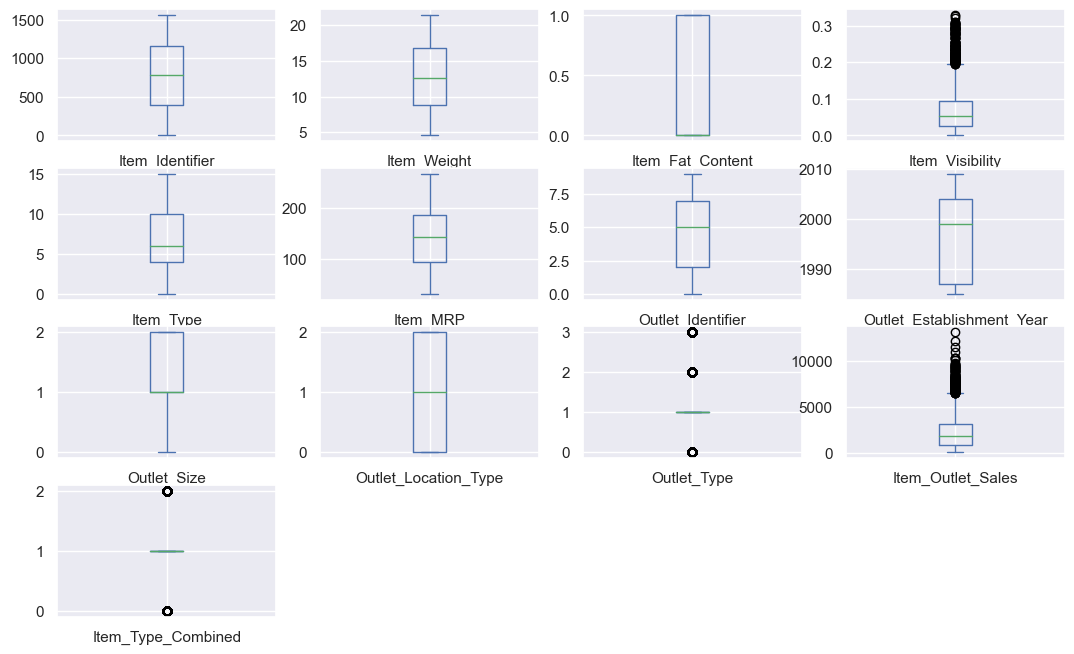

In [152]:
df.plot(kind="box", subplots=True, layout=(6,4), figsize=(13,12))

<AxesSubplot:title={'center':' The Distribution of Item Visibility with Sales'}, xlabel='Item_Visibility', ylabel='Item_Outlet_Sales'>

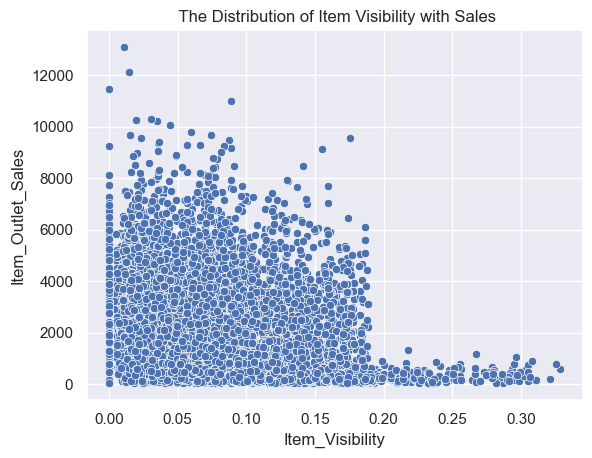

In [153]:
plt.title(" The Distribution of Item Visibility with Sales")
sns.scatterplot(data=df, x='Item_Visibility', y='Item_Outlet_Sales')

In [154]:
df = df[df['Item_Visibility'] < 0.3]

<AxesSubplot:title={'center':' The Distribution of Item Visibility with Sales after Outliers Removal'}, xlabel='Item_Visibility', ylabel='Item_Outlet_Sales'>

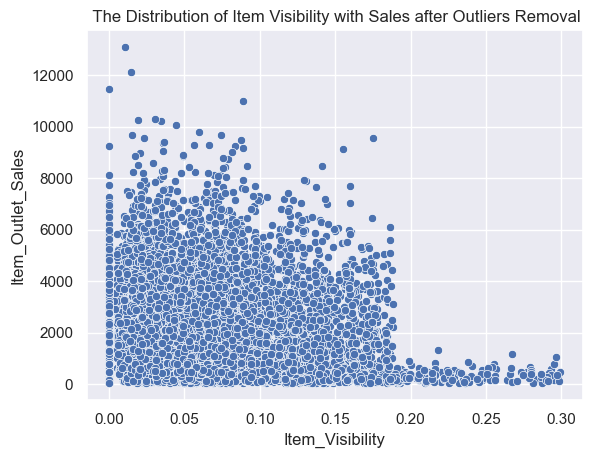

In [155]:
plt.title(" The Distribution of Item Visibility with Sales after Outliers Removal")
sns.scatterplot(data=df, x='Item_Visibility', y='Item_Outlet_Sales')

## Feature Selection

In [156]:
# dropping non relevant features
df.drop(columns=['Item_Identifier', 'Outlet_Identifier', 'Outlet_Establishment_Year'], axis=1, inplace=True)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_9972\1959568790.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['Item_Identifier', 'Outlet_Identifier', 'Outlet_Establishment_Year'], axis=1, inplace=True)


In [157]:
df.columns

Index(['Item_Weight', 'Item_Fat_Content', 'Item_Visibility', 'Item_Type',
       'Item_MRP', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type',
       'Item_Outlet_Sales', 'Item_Type_Combined'],
      dtype='object')

In [158]:
X = df.drop('Item_Outlet_Sales', axis=1)
y = df['Item_Outlet_Sales']

## Splitting

In [159]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3)

In [160]:
X.columns

Index(['Item_Weight', 'Item_Fat_Content', 'Item_Visibility', 'Item_Type',
       'Item_MRP', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type',
       'Item_Type_Combined'],
      dtype='object')

# Modelling:

## XGB-Regressor


In [161]:
# loading instance of xgbregressor
xgb = XGBRegressor()

In [162]:
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [163]:
y_xgb_prediction = xgb.predict(X_train)

In [164]:
round(xgb.score(X_train,y_train) *100,2), round(xgb.score(X_test, y_test) *100 ,2)

(86.56, 53.08)

In [165]:
# print(f"The Accuracy: {round(xgb.score(y_test, y_xgb_prediction), 2)}")
# print(f"R2 Score: {round(r2_score(y_test, y_xgb_prediction), 2)}")
# print(f"MAE: {round(mean_absolute_error(y_test, y_xgb_prediction), 2)}")

## Linear Regression

In [166]:
from sklearn.linear_model import LinearRegression

In [167]:
# create linear regression object
reg = LinearRegression()

In [168]:
# train the model using the training sets
reg.fit(X_train, y_train)

LinearRegression()

In [169]:
y_reg_prediction = reg.predict(X_train)

In [189]:
y_reg_prediction.reshape(-1, 1)

array([[1626.94169676],
       [1898.61693435],
       [1550.97768661],
       ...,
       [2622.92338389],
       [2413.49759444],
       [1356.09894901]])

In [170]:
round(reg.score(X_train,y_train) *100,2) , round(reg.score(X_test, y_test) *100,2)

(50.33, 50.35)

In [191]:
# print(f"The Accuracy: {round(reg.score(y_test, y_reg_prediction.reshape(-1, 1)), 2)}")
# print(f"R2 Score: {round(r2_score(y_test, y_reg_prediction.reshape(-1, 1)), 2)}")
# print(f"MAE: {round(mean_absolute_error(y_test, y_reg_prediction.reshape(-1, 1)), 2)}")

In [172]:
from sklearn.linear_model import Lasso

In [173]:
#lasso
ls = Lasso(alpha = 0.01)
ls.fit(X_train,y_train)

Lasso(alpha=0.01)

In [174]:
round(ls.score(X_train,y_train) *100,2) , round(ls.score(X_test, y_test) *100,2)

(50.33, 50.35)

# Scaling:

In [175]:
from sklearn.preprocessing import StandardScaler

In [176]:
scaler = StandardScaler()

In [177]:
X_train_ss = scaler.fit_transform(X_train)
X_test_ss = scaler.transform(X_test)

In [178]:
ls_ss = Lasso(alpha = 0.01)

In [180]:
#lasso
ls_ss.fit(X_train_ss,y_train)

Lasso(alpha=0.01)

In [182]:
round(ls_ss.score(X_train_ss,y_train) *100,2) , round(ls_ss.score(X_test_ss, y_test) *100,2)

(50.33, 50.35)